In [3]:
#all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from collections import defaultdict

from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI

best_k = 3 #change for different case


Text_Numeracy = "In a few sentences, please describe an experience in your life that demonstrated your knowledge of health or medical issues."
Text_Anxiety = "In a few sentences, please describe what makes you feel most anxious or worried when visiting the doctor's office."
Text_TrustPhys = "In a few sentences, please explain the reasons why you trust or distrust your primary care physician. If you do not have a primary care physician, please answer in regard to doctors in general."
Text_SubjectiveLit = "Regarding all the questions you just answered, to what degree do you feel you have the capacity to obtain, process, and understand basic health information and services needed to make appropriate health decisions? Please explain your answer in a few sentences."

## Table for demographic/behavioral/psychological features

In [2]:
# 文件路径
file_path = 'Data\Data_SurveyPlusDemographics.txt'

# 读取文件
data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')

data = data.dropna()

# Display the remaining number of rows after dropping missing values
remaining_rows = data.shape[0]
print(f'Remaining number of rows after dropping missing values: {remaining_rows}')

# 显示数据的前几行
print(data.head())

Remaining number of rows after dropping missing values: 8120
   File  Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...   D6  Dmed_7  \
0     1    1  5.0  5.0  4.0   5  3.0  1.0    3    1.0  ...  1.0    30.0   
1     1    2  4.0  4.0  4.0   4  3.0  1.0    3    2.0  ...  1.0    29.0   
2     1    3  5.0  5.0  4.0   4  3.0  1.0    3    1.0  ...  1.0    32.0   
3     1    4  5.0  5.0  4.0   4  3.0  4.0    3    1.0  ...  1.0    31.0   
4     1    5  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...  1.0    34.0   

   Dmed_8 DMed_1  DMed_2  DMed_3  DMed_9  Dmed_10  Dmed_5  Dmed_6  
0     152    4.0     1.0     4.0     3.0      5.0     1.0     1.0  
1     150    3.0     1.0     8.0     3.0      6.0     1.0     1.0  
2     160    1.0     1.0     4.0     6.0      5.0     1.0     1.0  
3     168    5.0     1.0    12.0     2.0      5.0     1.0     3.0  
4     220    5.0     1.0    12.0     3.0      4.0     7.0    15.0  

[5 rows x 123 columns]


C:\Users\howar\AppData\Local\Temp\ipykernel_8412\533319393.py:5: DtypeWarning: Columns (115) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')


In [3]:
demographic_list = [
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "D6",
    "Dmed_7",
    "Dmed_8"
]


behavioral_list  = [
    "DMed_1",
    "DMed_2",
    "DMed_3",
    "DMed_9",
    "Dmed_10",
    "Dmed_5",
    "Dmed_6",
    "HC_1",
    "HC_2",
    "HC_3",
    "HC_4",
    "HC_5",
    "Rx2"
]



psychological_list = [
    "ATQ_1",
    "ATQ_2",
    "ATQ_3",
    "ATQ_4",
    "ATQ_5",
    "ATQ_6",
    "ATQ_7",
    "ATQ_8",
    "TWB_1",
    "TWB_2",
    "TWB_3",
    "TWB_4",
    "TWB_5",
    "TWB_6",
    "TWB_7",
    "TWB_8",
    "TWB_9",
    "TWB_10",
    "RA1_1",
    "RA1_2",
    "RA1_3",
    "RA1_4",
    "RA1_5",
    "RA1_6",
    "RA1_7",
    "RA1_8",
    "RA1_9",
    "RA1_10",
    "STAI_1",
    "STAI_2",
    "STAI_3",
    "STAI_4",
    "STAI_5",
    "STAI_6",
    "STAI_7",
    "BSCS_1",
    "BSCS_2",
    "BSCS_3",
    "BSCS_4",
    "REI_1",
    "REI_2",
    "REI_3",
    "REI_4",
    "REI_5",
    "REI_6",
    "REI_7",
    "REI_8",
    "REI_9",
    "REI_10",
    "FIPI_1",
    "FIPI_2",
    "FIPI_3",
    "FIPI_4",
    "FIPI_5"
]

label_list = [
    "Text_Numeracy",
    "Text_Anxiety",
    "Text_TrustPhys",
    "Text_SubjectiveLit"
]


demographic_data = data[demographic_list]
behavioral_data = data[behavioral_list]
psychological_data = data[psychological_list]
labels = data[label_list]


In [35]:
train_data = data[demographic_list + behavioral_list]

In [36]:
import pandas as pd
import re


# 定义一个函数来清理数值数据
def clean_numeric(value):
    if isinstance(value, str):
        # 使用正则表达式提取数值部分
        numeric_value = re.findall(r'\d+', value)
        if numeric_value:
            return float(numeric_value[0])
        else:
            return None
    return value

# 清理数据，将所有列转换为数值类型
for column in train_data.columns:
    train_data[column] = train_data[column].apply(clean_numeric)

# 将数据转换为浮点型
train_data = train_data.astype(float)

# 获取第一行数据
first_row = train_data.iloc[0]

# 按列名、数据类型和内容分别打印
for column_name in train_data.columns:
    value = first_row[column_name]
    dtype = train_data[column_name].dtype
    print(f"{column_name} (Type: {dtype}): {value}")

# 检查清理后的数据
print(train_data.head())


D1 (Type: float64): 30.0
D2 (Type: float64): 2.0
D3 (Type: float64): 1.0
D4 (Type: float64): 6.0
D5 (Type: float64): 1.0
D6 (Type: float64): 1.0
Dmed_7 (Type: float64): 5.0
Dmed_8 (Type: float64): 150.0
DMed_1 (Type: float64): 3.0
DMed_2 (Type: float64): nan
DMed_3 (Type: float64): 3.0
DMed_9 (Type: float64): 3.0
Dmed_10 (Type: float64): 5.0
Dmed_5 (Type: float64): nan
Dmed_6 (Type: float64): 0.0
HC_1 (Type: float64): nan
HC_2 (Type: float64): nan
HC_3 (Type: float64): nan
HC_4 (Type: float64): nan
HC_5 (Type: float64): nan
Rx2 (Type: float64): nan
     D1   D2   D3   D4   D5   D6  Dmed_7  Dmed_8  DMed_1  DMed_2  ...  DMed_9  \
0  30.0  2.0  1.0  6.0  1.0  1.0     5.0   150.0     3.0     NaN  ...     3.0   
1  30.0  2.0  1.0  4.0  3.0  1.0     5.0   150.0     2.0     NaN  ...     3.0   
2  50.0  2.0  1.0  6.0  6.0  1.0     5.0   150.0     1.0     NaN  ...     6.0   
3  30.0  2.0  1.0  5.0  6.0  1.0     5.0   150.0     3.0     NaN  ...     0.0   
4  30.0  1.0  1.0  4.0  1.0  1.0     5.0

C:\Users\howar\AppData\Local\Temp\ipykernel_8412\2232870691.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].apply(clean_numeric)
C:\Users\howar\AppData\Local\Temp\ipykernel_8412\2232870691.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].apply(clean_numeric)
C:\Users\howar\AppData\Local\Temp\ipykernel_8412\2232870691.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

## Categorize into subgroups

In [37]:
# Transform numeric variables into categorical
# Age groups
bins = [1, 13, 23, 33, 43, 83] 
labels = ['18-29', '30-39', '40-49', '50-59', '60 and above']
train_data['D1'] = pd.cut(train_data['D1'], bins=bins, labels=labels, right=False)

# Height (in feet and inches) into categorical (example bins, adjust as necessary)
bins_height = [0, 5*12+4, 5*12+8, 6*12, 7*12]  # in inches
labels_height = ['<5\'4"', '5\'4"-5\'8"', '5\'8"-6\'0"', '>6\'0"']
train_data['Dmed_7'] = pd.cut(train_data['Dmed_7'], bins=bins_height, labels=labels_height, right=False)

# Weight into categories (example bins, adjust as necessary)
bins_weight = [0, 125, 150, 175, 200, np.inf]
labels_weight = ['<125 lbs', '125-150 lbs', '150-175 lbs', '175-200 lbs', '>200 lbs']
train_data['Dmed_8'] = pd.cut(train_data['Dmed_8'], bins=bins_weight, labels=labels_weight, right=False)


#behavioral
def convert_to_categorical(df):
    # 转换处方药物数量
    df['DMed_1'] = pd.cut(df['DMed_1'], bins=[-1, 1, 3, float('inf')], labels=['1 or less', '2-3', 'More than 3'])

    # 将是否有主要护理医师的回答转为分类数据
    df['DMed_2'] = df['DMed_2'].apply(lambda x: 'Yes' if x == 1 else 'No')

    # 转换过去两年访问主要护理医师的次数
    df['DMed_3'] = pd.cut(df['DMed_3'], bins=[-1, 2, 5, float('inf')], labels=['0-2 times', '3-5 times', 'More than 5 times'])

    # 转换每周运动小时数
    df['DMed_9'] = pd.cut(df['DMed_9'], bins=[-1, 2, 5, 10, float('inf')], labels=['0-2 hours', '3-5 hours', '6-10 hours', 'More than 10 hours'])

    # 转换吸烟频率
    df['Dmed_5'] = pd.cut(df['Dmed_5'], bins=[-1, 0, 10, 30], labels=['Non-smoker', 'Occasional smoker', 'Regular smoker'])

    # 转换每周饮酒量
    df['Dmed_6'] = pd.cut(df['Dmed_6'], bins=[-1, 2, 5, float('inf')], labels=['0-2 drinks', '3-5 drinks', 'More than 5 drinks'])

    # 转换健康意识相关问题
    health_statements = ['HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5']
    for col in health_statements:
        df[f'{col}'] = pd.cut(df[col], bins=[0, 2, 4, 5], labels=['Disagree', 'Neutral', 'Agree'])

    # 转换健康总体描述
    df['Rx2'] = pd.cut(df['Rx2'], bins=[0, 2, 4, 5], labels=['Poor', 'Fair', 'Good'])

    return df


train_data = convert_to_categorical(train_data)

In [19]:
train_data

,D1,D2,D3,D4,D5,D6,Dmed_7,Dmed_8,DMed_1,DMed_2,...,DMed_9,Dmed_10,Dmed_5,Dmed_6,HC_1,HC_2,HC_3,HC_4,HC_5,Rx2
0,30-39,2.0,1.0,6.0,1.0,1.0,"<5'4""",150-175 lbs,More than 3,Yes,...,3-5 hours,5.0,Occasional smoker,0-2 drinks,Agree,Agree,Agree,Agree,Neutral,Fair
1,30-39,2.0,1.0,4.0,3.0,1.0,"<5'4""",150-175 lbs,2-3,Yes,...,3-5 hours,6.0,Occasional smoker,0-2 drinks,Agree,Agree,Agree,Agree,Agree,Fair
2,50-59,2.0,1.0,6.0,6.0,1.0,"<5'4""",150-175 lbs,1 or less,Yes,...,6-10 hours,5.0,Occasional smoker,0-2 drinks,Neutral,Neutral,Neutral,Neutral,Neutral,Fair
3,30-39,2.0,1.0,5.0,6.0,1.0,"<5'4""",150-175 lbs,More than 3,Yes,...,0-2 hours,5.0,Occasional smoker,3-5 drinks,Neutral,Neutral,Agree,Neutral,Neutral,Fair
4,30-39,1.0,1.0,4.0,1.0,1.0,"<5'4""",>200 lbs,More than 3,Yes,...,3-5 hours,4.0,Occasional smoker,More than 5 drinks,Agree,Agree,Agree,Agree,Neutral,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,50-59,2.0,2.0,5.0,3.0,1.0,"<5'4""",<125 lbs,1 or less,Yes,...,3-5 hours,5.0,Occasional smoker,0-2 drinks,Agree,Agree,Agree,Agree,Neutral,Fair
8498,18-29,2.0,2.0,4.0,1.0,1.0,"<5'4""",>200 lbs,1 or less,Yes,...,6-10 hours,5.0,Occasional smoker,More than 5 drinks,Agree,Agree,Agree,Agree,Agree,Fair
8499,60 and above,1.0,1.0,5.0,6.0,1.0,"<5'4""",>200 lbs,2-3,Yes,...,6-10 hours,5.0,Occasional smoker,0-2 drinks,Agree,Agree,Agree,Agree,Agree,Fair
8500,40-49,2.0,2.0,5.0,3.0,1.0,"<5'4""",125-150 lbs,1 or less,Yes,...,3-5 hours,4.0,Occasional smoker,0-2 drinks,Disagree,Disagree,Agree,Disagree,Disagree,Fair


In [20]:
# Ensure all features are treated as categorical
train_data = train_data.astype('category')

In [21]:
# One-hot encode all categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(train_data)
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(train_data.columns))

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
reduced_data = umap.fit_transform(encoded_categorical_df)

def test_k_values(reduced_data, max_k):
    silhouette_scores = []
    k_values = range(2, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_data)
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {k}, the average silhouette score is: {silhouette_avg:.4f}')
    return k_values, silhouette_scores

# Test k values from 2 to 15
k_values, silhouette_scores = test_k_values(reduced_data, 15)

c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


For n_clusters = 2, the average silhouette score is: 0.3588
For n_clusters = 3, the average silhouette score is: 0.4231
For n_clusters = 4, the average silhouette score is: 0.3911
For n_clusters = 5, the average silhouette score is: 0.3932
For n_clusters = 6, the average silhouette score is: 0.4185
For n_clusters = 7, the average silhouette score is: 0.4136
For n_clusters = 8, the average silhouette score is: 0.4136
For n_clusters = 9, the average silhouette score is: 0.4104
For n_clusters = 10, the average silhouette score is: 0.4022
For n_clusters = 11, the average silhouette score is: 0.4119
For n_clusters = 12, the average silhouette score is: 0.4028
For n_clusters = 13, the average silhouette score is: 0.4047
For n_clusters = 14, the average silhouette score is: 0.3896
For n_clusters = 15, the average silhouette score is: 0.3946


Silhouette Score for K-means with 3: 0.4231


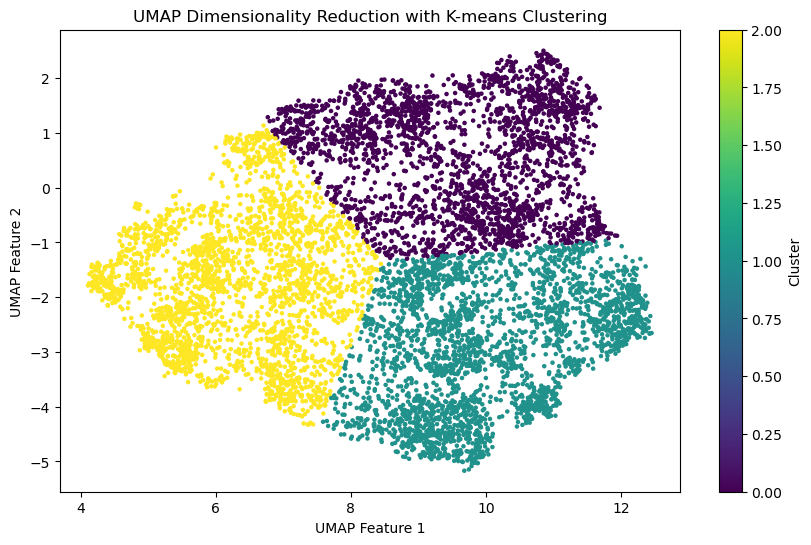

In [22]:
# Apply K-means with k=4
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)

# Add cluster labels to the original data
train_data['clusters'] = cluster_labels
data['clusters'] = cluster_labels

# Evaluate clustering
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print(f'Silhouette Score for K-means with {best_k}: {silhouette_avg:.4f}')

# Plot UMAP result with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title('UMAP Dimensionality Reduction with K-means Clustering')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.colorbar(label='Cluster')
plt.show()

In [23]:
data[train_data.columns] = train_data

# 分割数据集为7个子数据集
clustered_datasets = {}
for i in range(best_k):
    clustered_datasets[f'Cluster_{i}'] = data[data['clusters'] == i]

# 显示每个子数据集的前几行，验证分割的正确性
for cluster, dataset in clustered_datasets.items():
    print(f"Dataset for {cluster} (first 5 rows):")
    print(dataset.head())
    print("\n")

Dataset for Cluster_0 (first 5 rows):
    File  Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...  Dmed_7  \
4      1    5  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...   <5'4"   
5      1    6  5.0  5.0  5.0   4  3.0  1.0    3    1.0  ...   <5'4"   
9      1   10  5.0  5.0  5.0   4  3.0  1.0    3    1.0  ...   <5'4"   
13     1   14  5.0  5.0  5.0   4  3.0  1.0    3    1.0  ...   <5'4"   
16     1   17  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...   <5'4"   

         Dmed_8       DMed_1 DMed_2             DMed_3     DMed_9  Dmed_10  \
4      >200 lbs  More than 3    Yes  More than 5 times  3-5 hours      4.0   
5   175-200 lbs    1 or less    Yes          0-2 times  0-2 hours      1.0   
9   175-200 lbs    1 or less     No          0-2 times  0-2 hours      6.0   
13     <125 lbs  More than 3    Yes  More than 5 times  0-2 hours      5.0   
16     >200 lbs          2-3    Yes          3-5 times  0-2 hours      2.0   

               Dmed_5              Dmed_6  clusters  
4   Occasion

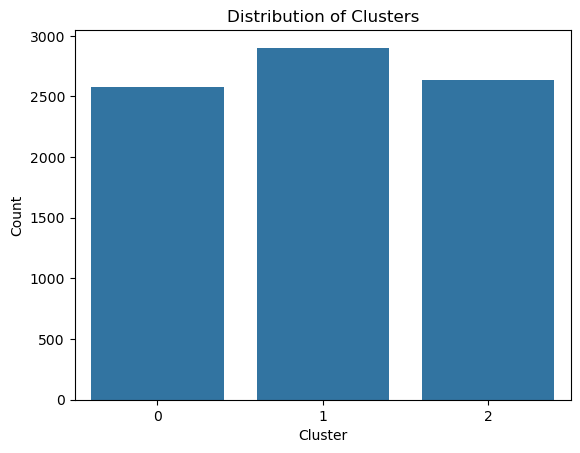

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制条形图
sns.countplot(x='clusters', data=data)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## 2. Pretrain GPT Model

In [25]:
import os

# 创建文件夹
output_dir = 'Data/clusters/demographic_only'
os.makedirs(output_dir, exist_ok=True)

### GPT4

In [30]:
# 假设 data 是你的Pandas DataFrame
output_dir_train = 'Data\clusters\demographic_and_behavioral/train'
output_dir_test = 'Data\clusters\demographic_and_behavioral/test'

if not os.path.exists(output_dir_train):
    os.makedirs(output_dir_train)

if not os.path.exists(output_dir_test):
    os.makedirs(output_dir_test)

In [31]:
#condition?
def convert_to_prompt_demo(row):
    # Age
    age = f"{row['D1']} years old" if not pd.isna(row['D1']) else "unknown age"
    
    # Sex
    sex = "male" if row['D2'] == 1 else "female" if row['D2'] == 2 else "unknown sex"
    
    # Race
    race_options = [
        "White", "Black or African American", "Asian", 
        "Native American or American Indian", "Native Hawaiian or Pacific Islander", 
        "Multiracial or biracial", "Other", "Prefer not to say"
    ]
    race = race_options[int(row['D3']) - 1] if not pd.isna(row['D3']) else "unknown race"
    
    # Education
    education_options = [
        "8th grade or less", "some high school education", "high school graduate", 
        "some college education", "college graduate", "some graduate school education", 
        "a graduate or professional degree", "prefer not to say"
    ]
    education = education_options[int(row['D4']) - 1] if not pd.isna(row['D4']) else "unknown educational background"
    
    # Income
    income_options = [
        "less than $20,000", "$20,000 - $34,999", "$35,000 - $54,999", 
        "$55,000 - $74,999", "$75,000 - $89,999", "$90,000 or more", 
        "unknown income", "prefer not to say"
    ]
    income = income_options[int(row['D5']) - 1] if not pd.isna(row['D5']) else "unknown income"
    
    # Language
    english_first_lang = "English is your first language" if row['D6'] == 1 else \
                         "English is not your first language" if row['D6'] == 2 else \
                         "it is unknown if English is your first language"
    
    # Physical measurements
    height = f"{row['Dmed_7']} feet tall" if not pd.isna(row['Dmed_7']) else "unknown height"
    weight = f"weighs {row['Dmed_8']} pounds" if not pd.isna(row['Dmed_8']) else "unknown weight"
    
    # Combine all into one prompt
    prompt = (
        f"You are {age}, {sex}, of {race} descent. You have {education} and an annual income of {income}. "
        f"{english_first_lang}. You are {height} and {weight}."
    )
    
    return prompt


def convert_to_prompt_behavioral(row):
    intro = "You are someone who "

    # 根据药物数量
    if row['DMed_1'] == '1 or less':
        intro += "takes few or no prescription drugs regularly, "
    elif row['DMed_1'] == '2-3':
        intro += "takes a moderate number of prescription drugs regularly, "
    else:
        intro += "takes many prescription drugs regularly, "

    # 根据是否有主要护理医师
    if row['DMed_2'] == 'Yes':
        intro += "has a primary care physician, "
    else:
        intro += "does not have a primary care physician, "

    # 根据访问医师的频率
    if row['DMed_3'] == '0-2 times':
        intro += "and rarely visits them. "
    elif row['DMed_3'] == '3-5 times':
        intro += "and occasionally visits them. "
    else:
        intro += "and frequently visits them. "

    # 根据运动小时数
    if row['DMed_9'] == '0-2 hours':
        intro += "You engage in little physical activity weekly. "
    elif row['DMed_9'] == '3-5 hours':
        intro += "You have a moderate weekly physical activity. "
    elif row['DMed_9'] == '6-10 hours':
        intro += "You are quite active physically on a weekly basis. "
    else:
        intro += "You are very active, engaging in many hours of physical activity every week. "

    # 结合健康意识
    if row['HC_1'] == 'Agree':
        intro += "Living in the best possible health is very important to you. "

    return intro


In [32]:

# 分割数据集为7个子数据集并进行训练/测试分割
clustered_datasets = {}
train_datasets = {}
test_datasets = {}

for i in range(best_k):  
    cluster_data = data[data['clusters'] == i].head(100)
    train, test = train_test_split(cluster_data, test_size=0.2, random_state=42)  # 20% 数据作为测试集
    train_datasets[f'Cluster_{i}'] = train
    test_datasets[f'Cluster_{i}'] = test


def convert_to_jsonl_format(clustered_datasets, output_dir):
    for cluster, dataset in clustered_datasets.items():
        # Fill missing values
        
        jsonl_data = []
        for index, row in dataset.iterrows():
            system_prompt = "You should simulate a specified person's persona based on the background information I provided. You are currently visiting a psychologist." + convert_to_prompt_demo(row) + convert_to_prompt_behavioral(row)
            # Combining the responses into the completion field
            jsonl_data.append({
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": Text_SubjectiveLit},
                    {"role": "assistant", "content": row['Text_SubjectiveLit']},
                    {"role": "user", "content": Text_TrustPhys},
                    {"role": "assistant", "content": row['Text_TrustPhys']},
                    {"role": "user", "content": Text_Anxiety},
                    {"role": "assistant", "content": row['Text_Anxiety']},
                    {"role": "user", "content": Text_Numeracy},
                    {"role": "assistant", "content": row['Text_Numeracy']}
                ]
                })
                
        # Saving the jsonl files
        filename = os.path.join(output_dir, f"{cluster}.jsonl")
        with open(filename, 'w') as f:
            for entry in jsonl_data:
                f.write(json.dumps(entry) + "\n")
        print(f"Saved {filename}")


# 转换训练数据和测试数据为JSON格式并保存
convert_to_jsonl_format(train_datasets, output_dir_train)
convert_to_jsonl_format(test_datasets, output_dir_test)


Saved Data\clusters\demographic_and_behavioral/train\Cluster_0.jsonl
Saved Data\clusters\demographic_and_behavioral/train\Cluster_1.jsonl
Saved Data\clusters\demographic_and_behavioral/train\Cluster_2.jsonl
Saved Data\clusters\demographic_and_behavioral/test\Cluster_0.jsonl
Saved Data\clusters\demographic_and_behavioral/test\Cluster_1.jsonl
Saved Data\clusters\demographic_and_behavioral/test\Cluster_2.jsonl


In [33]:
#modify
data_path = "Data\clusters\demographic_and_behavioral/train\Cluster_1.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 80
First example:
{'role': 'system', 'content': 'You should simulate a specified person\'s persona based on the background information I provided. You are currently visiting a psychologist.You are 30-39 years old, male, of White descent. You have high school graduate and an annual income of $20,000 - $34,999. English is your first language. You are <5\'4" feet tall and weighs 150-175 lbs pounds.You are someone who takes few or no prescription drugs regularly, has a primary care physician, and occasionally visits them. You engage in little physical activity weekly. '}
{'role': 'user', 'content': 'Regarding all the questions you just answered, to what degree do you feel you have the capacity to obtain, process, and understand basic health information and services needed to make appropriate health decisions? Please explain your answer in a few sentences.'}
{'role': 'assistant', 'content': 'I feel I have a pretty good grasp on understanding the various aspects of healthcare. 

In [38]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


## 4. Testing results

In [9]:
models = ["ft:gpt-3.5-turbo-0125:personal:demo-beha-0:9l3EDB0v",
          "ft:gpt-3.5-turbo-0125:personal:demo-beha-1:9l3Gtr8M",
            "ft:gpt-3.5-turbo-0125:personal:demo-beha-2:9l3Elf7J",
            "gpt-3.5-turbo-0125"
            ]

user_prompt = {"Text_Numeracy": Text_Numeracy, 
               "Text_Anxiety": Text_Anxiety, 
               "Text_TrustPhys": Text_TrustPhys, 
               "Text_SubjectiveLit": Text_SubjectiveLit}

In [4]:
from openai import OpenAI
import json
from collections import defaultdict

client = OpenAI()

#response from a single person (i = which model, j = resp from jth question)
def perfromace_across_models(models, system_prompt, user_prompt):
  response_list = defaultdict(lambda: {prompt: [] for prompt in user_prompt})
  for i, model in enumerate(models):
    for j in user_prompt:
      response = client.chat.completions.create(
        model= model,
        messages=[{"role": "system", "content": system_prompt}, 
                  {"role": "user", "content": user_prompt[j]}],
        temperature=1,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
      ).choices[0].message.content
      response_list[i][j].append(response)
  
  return response_list


def dict_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: dict_to_regular(v) for k, v in d.items()}
    return d



In [5]:
# Path to the uploaded file
file_paths = [f'Data\clusters\demographic_and_behavioral/test\Cluster_{i}.jsonl' for i in range(best_k)]

# Reading the JSONL file and converting it to a list of dictionaries
datas = []

for file_path in file_paths:
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    datas.append(data)

In [6]:
#j = jth cluster
for j, data in enumerate(datas):
    all_responses = []
    all_labels = []

    for i in range(len(data)):
        labels =  {prompt: "" for prompt in user_prompt}
        system_prompt = data[i]["messages"][0]["content"] #peronal information
        q1 = data[i]["messages"][2]["content"]  #answer for q1
        q2 = data[i]["messages"][4]["content"]
        q3 = data[i]["messages"][6]["content"]
        q4 = data[i]["messages"][8]["content"]

        user_response = perfromace_across_models(models, system_prompt, user_prompt)
        #user_response[i][j] = ith model's jth question's  response 
        labels['Text_Numeracy'] = q1
        labels['Text_Anxiety'] = q2
        labels['Text_TrustPhys'] = q3
        labels['Text_SubjectiveLit'] = q4
        
        all_responses.append(user_response)
        all_labels.append(labels)

    all_responses_output_dir = f"results/cluster_{j}/all_responses_demo_beha.json"
    all_labels_output_dir = f"results/cluster_{j}/all_labels_demo_beha.json"

    os.makedirs(os.path.dirname(all_responses_output_dir), exist_ok=True)
    os.makedirs(os.path.dirname(all_labels_output_dir), exist_ok=True)

    # 将 all_responses 中的 defaultdict 转换为普通字典
    all_responses_regular = [dict_to_regular(d) for d in all_responses]

    # 序列化为 JSON 并保存到文件
    with open(all_responses_output_dir, 'w') as f:
        json.dump(all_responses_regular, f)

    with open(all_labels_output_dir, 'w') as f:
        json.dump(all_labels, f)


## Evaluation methods

In [6]:
all_responses = []
all_labels = []

#all_response[clust][i][j][k] = [nth clust][ith person][jth model][kth question]
#all_labels[clust][i][k] = [nth clust][ith person][kth question]

# 从文件中读取并反序列化 JSON 的函数
def regular_to_defaultdict(d):
    if isinstance(d, dict):
        return defaultdict(lambda: {prompt: [] for prompt in user_prompt},
                           {k: regular_to_defaultdict(v) for k, v in d.items()})
    return d

for i in range(best_k):
    # 从文件中读取 JSON 数据并转换回 defaultdict
    with open(f'results/cluster_{i}/all_responses_demo_beha.json', 'r') as f:
        all_responses_loaded = json.load(f)

    with open(f'results/cluster_{i}/all_labels_demo_demo_beha.json', 'r') as f:
        all_labels_loaded = json.load(f)

    all_responses.append([regular_to_defaultdict(d) for d in all_responses_loaded])
    all_labels.append([d for d in all_labels_loaded])

### 1. Text Similarity

In [9]:
def calculate_similarity(paragraph1, paragraph2):
    # Load the pre-trained SBERT model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Encode the paragraphs using the SBERT model
    embeddings1 = model.encode(paragraph1)
    embeddings2 = model.encode(paragraph2)

    # Reshape embeddings to 2D arrays for cosine similarity calculation
    embeddings1 = embeddings1.reshape(1, -1)
    embeddings2 = embeddings2.reshape(1, -1)

    similarity = cosine_similarity(embeddings1, embeddings2)
    return similarity

In [10]:
all_responses

[[defaultdict(<function __main__.regular_to_defaultdict.<locals>.<lambda>()>,
              {'0': defaultdict(<function __main__.regular_to_defaultdict.<locals>.<lambda>()>,
                           {'Text_Numeracy': ["I remember one day when i was running relays at my high school , I was in such a hurry because I won two races already and I wanted to win the 3rd one also , I literally had no time to stop and eat a full meal so I just drank water and snacked on chips all day..by the time the race came all right before the race started all i had was a chocolate milk and an apple I told my coach that I wasn't feeling well and he just brushed me off and said I was just scared..so I got ready for the race feeling like I could barely keep my eyes open and I still went out there and ran in the middle of the race I got this knot in my chest and it was hard to swallow and i started dry heaving , I was still determined to finish the race so i did but then my mom came to see me after the race 

In [13]:
all_similarities = {f"cluster_{j}" : [] for j in range(best_k)}

for clust in range(len(all_labels)):
    similarities = []
    for i, person in enumerate(all_labels[clust]):
        label = [person["Text_Numeracy"], person["Text_Anxiety"], person["Text_TrustPhys"], person["Text_SubjectiveLit"]]
        
        answer_models = [
            [all_responses[clust][i][str(model_idx)]["Text_Numeracy"],
             all_responses[clust][i][str(model_idx)]["Text_Anxiety"],
             all_responses[clust][i][str(model_idx)]["Text_TrustPhys"],
             all_responses[clust][i][str(model_idx)]["Text_SubjectiveLit"]]
            for model_idx in range(len(models))
        ]

        scores = [[] for _ in range(len(models))]  # 存放5个模型的分数

        for j in range(len(label)):
            for model_idx in range(len(models)):
                scores[model_idx].append(calculate_similarity(label[j], answer_models[model_idx][j]))

        similarities.append(scores)  # 包含所有模型的分数
    all_similarities[f"cluster_{clust}"] = similarities


c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resum

In [ ]:
''' 
structure of all_similarities
{
    "cluster_0": [
        # Person 0 in cluster_0
        [
            [similarity_Numeracy_model0, similarity_Anxiety_model0, similarity_TrustPhys_model0, similarity_SubjectiveLit_model0],  # model 0 scores
            [similarity_Numeracy_model1, similarity_Anxiety_model1, similarity_TrustPhys_model1, similarity_SubjectiveLit_model1],  # model 1 scores
            [similarity_Numeracy_model2, similarity_Anxiety_model2, similarity_TrustPhys_model2, similarity_SubjectiveLit_model2],  # model 2 scores
            [similarity_Numeracy_model3, similarity_Anxiety_model3, similarity_TrustPhys_model3, similarity_SubjectiveLit_model3],  # model 3 scores
            [similarity_Numeracy_regular, similarity_Anxiety_regular, similarity_TrustPhys_regular, similarity_SubjectiveLit_regular]  # regular model scores
        ],
        # Person 1 in cluster_0
        [
            [similarity_Numeracy_model0, similarity_Anxiety_model0, similarity_TrustPhys_model0, similarity_SubjectiveLit_model0],
            [similarity_Numeracy_model1, similarity_Anxiety_model1, similarity_TrustPhys_model1, similarity_SubjectiveLit_model1],
            [similarity_Numeracy_model2, similarity_Anxiety_model2, similarity_TrustPhys_model2, similarity_SubjectiveLit_model2],
            [similarity_Numeracy_model3, similarity_Anxiety_model3, similarity_TrustPhys_model3, similarity_SubjectiveLit_model3],
            [similarity_Numeracy_regular, similarity_Anxiety_regular, similarity_TrustPhys_regular, similarity_SubjectiveLit_regular]
        ],
        # More people in cluster_0
    ],
    "cluster_1": [
        # Similar structure as cluster_0
    ],
    # More clusters
}

'''

In [14]:

# Calculate average similarities for each model in each cluster
best_models = {}

for clust, sim_list in all_similarities.items():
    cluster_similarities = np.array(sim_list)
    average_model_similarities = np.mean(cluster_similarities, axis=(0, 1))  # Axis 0 is people, axis 1 is fields

    best_model_idx = np.argmax(average_model_similarities)
    best_models[clust] = best_model_idx

    print(f"Cluster {clust}, Best model: model{best_model_idx} with average similarity: {average_model_similarities[best_model_idx]}")

# Print the best models for all clusters
print("Best models for all clusters:", best_models)

Cluster cluster_0, Best model: model1 with average similarity: [[0.30809313]]
Cluster cluster_1, Best model: model1 with average similarity: [[0.3003138]]
Cluster cluster_2, Best model: model2 with average similarity: [[0.3421567]]
Best models for all clusters: {'cluster_0': 1, 'cluster_1': 1, 'cluster_2': 2}


### 2. LLM as judge? comparing responses between label & different models

Dimensions：
1. similarity on decision
2. similarity on personality
3. hallucination
4. stability


In [7]:
judger = OpenAI()
system_judger_prompt = "You are a professional psychologist with extensive experience in evaluating textual responses for various psychological and cognitive dimensions. "

def get_response(judger, message):
    response = judger.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_judger_prompt},
            {"role": "user", "content": message}
        ]
    )
    return response.choices[0].message.content

def extract_numeric_score(response_text):
    match = re.search(r"(\d+(\.\d+)?)", response_text)
    if match:
        return float(match.group(1))
    else:
        return 0.0
    
def calculate_similarity_llm(label, answer):
    dimensions = ["similarity on decision", "similarity on personality", "hallucination", "stability"]
    scores = []
    for dimension in dimensions:
        message = f"Evaluate the following model response based on the dimension of '{dimension}' comparing to the label response:\n\nLabel response: {label}\nModel response: {answer}\n\nScore (1-10). Please only output the number."
        score_text = get_response(judger, message)
        score = extract_numeric_score(score_text)
        scores.append(score)
    return sum(scores) / len(scores)

In [11]:
all_similarities = {f"cluster_{j}" : [] for j in range(best_k)}

for clust in range(len(all_labels)):
    similarities = []
    for i, person in enumerate(all_labels[clust]):
        label = [person["Text_Numeracy"], person["Text_Anxiety"], person["Text_TrustPhys"], person["Text_SubjectiveLit"]]
        
        answer_models = [
            [all_responses[clust][i][str(model_idx)]["Text_Numeracy"],
             all_responses[clust][i][str(model_idx)]["Text_Anxiety"],
             all_responses[clust][i][str(model_idx)]["Text_TrustPhys"],
             all_responses[clust][i][str(model_idx)]["Text_SubjectiveLit"]]
            for model_idx in range(5)
        ]

        scores = [[] for _ in range(5)]  # 存放5个模型的分数

        for j in range(len(label)):
            for model_idx in range(5):
                scores[model_idx].append(calculate_similarity_llm(label[j], answer_models[model_idx][j]))

        similarities.append(scores)  # 包含所有模型的分数
    all_similarities[f"cluster_{clust}"] = similarities


In [12]:
import numpy as np

best_models = {}
all_scores = {}

for clust, sim_list in all_similarities.items():
    cluster_similarities = np.array(sim_list)
    
    # Calculate the mean similarity for each model across all fields for each person
    mean_similarities_per_person = np.mean(cluster_similarities, axis=2)
    
    # Calculate the average similarity for each model across all people
    average_model_similarities = np.mean(mean_similarities_per_person, axis=0)
    
    best_model_idx = np.argmax(average_model_similarities)
    best_models[clust] = best_model_idx
    all_scores[clust] = average_model_similarities

    print(f"Cluster {clust}, Model scores: {average_model_similarities}")
    print(f"Cluster {clust}, Best model: model{best_model_idx} with average similarity: {average_model_similarities[best_model_idx]}")

# Print the best models for all clusters
print("Best models for all clusters:", best_models)


Cluster cluster_0, Model scores: [2.6625  2.725   2.7375  3.35    3.49375]
Cluster cluster_0, Best model: model4 with average similarity: 3.49375
Cluster cluster_1, Model scores: [2.425    2.771875 2.728125 3.378125 3.84375 ]
Cluster cluster_1, Best model: model4 with average similarity: 3.84375
Cluster cluster_2, Model scores: [2.7421875 2.7625    2.5765625 3.4375    3.75     ]
Cluster cluster_2, Best model: model4 with average similarity: 3.75
Best models for all clusters: {'cluster_0': 4, 'cluster_1': 4, 'cluster_2': 4}
